In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
from dispatches.case_studies.renewables_case.double_loop_utils import read_rts_gmlc_wind_inputs, prescient_outputs_for_gen
from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.load_parameters import wind_cap_cost, wind_op_cost, pem_cap_cost, pem_op_cost, pem_var_cost, PA
from dispatches_data.api import files

import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

rt_revenue_only = True
include_wind_capital_cost = False
shortfall_price = 1000
h2_price = 3

# Surrogate Design Results

## Pricetaker Results

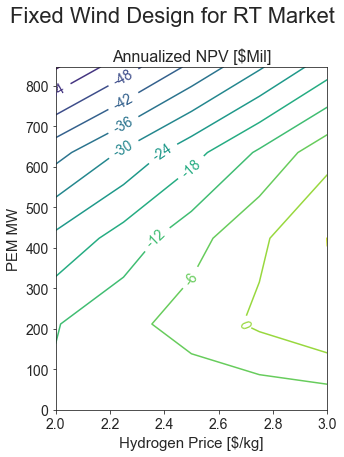

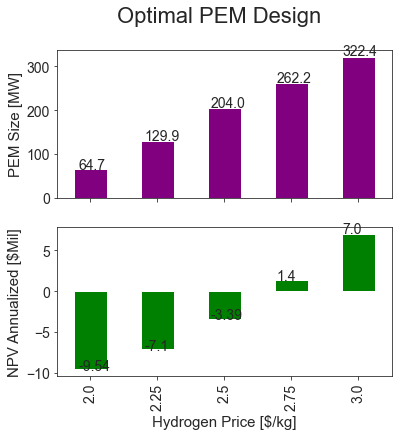

In [2]:
res_df = pd.read_csv("wind_PEM/wind_PEM_RT_1000.csv").drop('Unnamed: 0', axis=1)
res_df['NPV [$Mil]'] = res_df['NPV'] * 1e-6
pem_elec = res_df['annual_rev_h2'] * 54.953 / h2_price / 1e3
cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + res_df['pem_mw'] * pem_cap_cost) * 1e3 
fixed_op_cost = (847 * wind_op_cost + res_df['pem_mw'] * pem_op_cost) * 1e3
var_op_cost = pem_var_cost * pem_elec
res_df['annual_rev_E'] += fixed_op_cost + var_op_cost             # original run included the costs in the reported e_revenue
res_df['annual_rev_E_mil'] = res_df['annual_rev_E'] * 1e-6
res_df['annual_rev_h2_mil'] = res_df['annual_rev_h2'] * 1e-6
res_df['NPV Annualized [$Mil]'] = ((res_df['annual_rev_h2'] + res_df['annual_rev_E'] - fixed_op_cost - var_op_cost) - cap_cost / PA) * 1e-6

colormaps = [sns.color_palette("Purples", as_cmap=True), # NPV
             sns.color_palette("Greens", as_cmap=True), # PEM
             ]

def plot_results(results, title):
    fig, axs = plt.subplots(1, 1, figsize=(5, 6.5))
    pivot_tab = results.pivot_table(index='pem_mw', 
                                    columns="h2_price_per_kg", 
                                    values='NPV Annualized [$Mil]',
                                    aggfunc='mean')
    cp = axs.contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
    plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
    axs.set_title('Annualized NPV [$Mil]')
    axs.set_xlabel("Hydrogen Price [$/kg]")
    axs.set_ylabel("PEM MW")
    fig.suptitle(title)

pem_sizes = np.linspace(0, 1, 5) * 847
plot_results(res_df[res_df['pem_mw'].isin(pem_sizes)], "Fixed Wind Design for RT Market")
plt.tight_layout()
plt.savefig("pem_pricetaker.png")

opt_df = res_df[~res_df['pem_mw'].isin(pem_sizes)][['pem_mw', 'NPV Annualized [$Mil]', 'h2_price_per_kg']]
opt_df.set_index("h2_price_per_kg", inplace=True)
axes = opt_df.plot.bar(subplots=True, color={"pem_mw": "purple", 'NPV Annualized [$Mil]': "green"}, figsize=(6, 6), legend=None)
axes[0].set_xlabel("Hydrogen Price [$/kg]")
axes[1].set_xlabel("Hydrogen Price [$/kg]")
axes[0].set_ylabel("PEM Size [MW]")
axes[0].set_title("")
axes[1].set_title("")
axes[1].set_ylabel('NPV Annualized [$Mil]')
plt.suptitle("Optimal PEM Design")

for ax in axes:
    for n, p in enumerate(ax.patches):
        ax.annotate(str(round(p.get_height(), 2)), (n * p.get_width() * 1.97 + -.18, p.get_height() * 1.01))


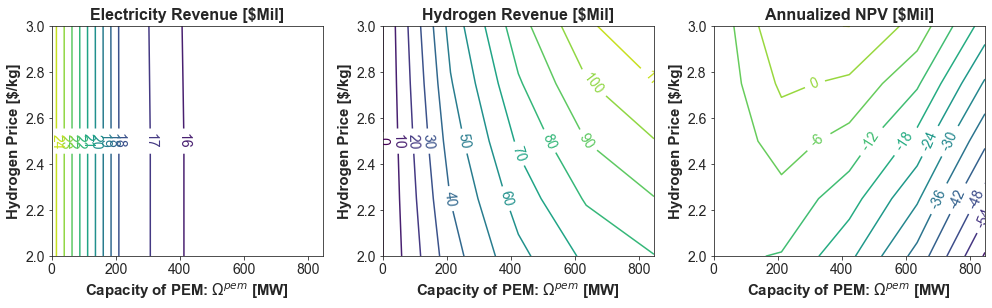

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))

res_df = res_df[res_df['pem_mw'].isin(pem_sizes)]
pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='annual_rev_E_mil',
                                aggfunc='mean')
cp = axs[0].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[0].set_title("Electricity Revenue [$Mil]", weight='bold')
axs[0].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[0].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='annual_rev_h2_mil',
                                aggfunc='mean')
cp = axs[1].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[1].set_title("Hydrogen Revenue [$Mil]", weight='bold')
axs[1].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[1].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='NPV Annualized [$Mil]',
                                aggfunc='mean')
cp = axs[2].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[2].set_title("Annualized NPV [$Mil]", weight='bold')
axs[2].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[2].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

# plt.suptitle("Results from Price-taker")
plt.tight_layout()
plt.savefig("pem_pricetaker.pdf")

In [4]:
res_df.sort_values("NPV").tail(1)

,wind_mw,wind_mw_ub,batt_mw,pem_mw,pem_bar,pem_temp,tank_size,tank_type,turb_mw,h2_price_per_kg,annual_rev_h2,annual_rev_E,NPV,NPV [$Mil],annual_rev_E_mil,annual_rev_h2_mil,NPV Annualized [$Mil]
26,847.0,10000,0.0,423.5,1.01325,300,0,simple,1,3.0,8.595274e+07,1.587225e+07,6.810097e+07,68.100966,15.872251,85.952745,6.049234


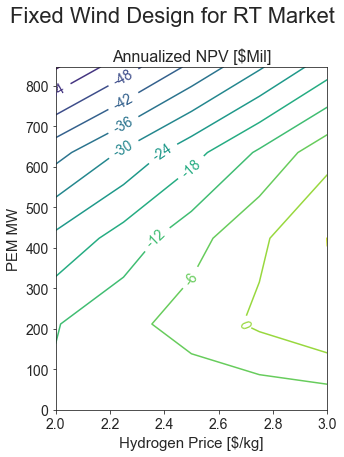

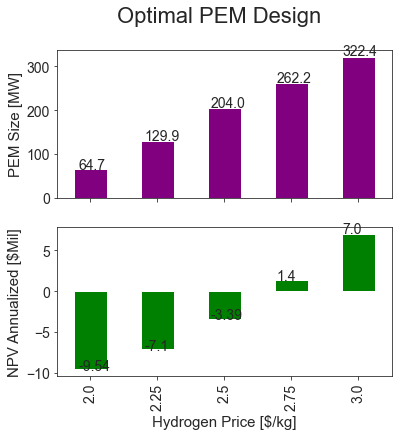

In [5]:
res_df = pd.read_csv("wind_PEM/wind_PEM_RT_1000.csv").drop('Unnamed: 0', axis=1)
res_df['NPV [$Mil]'] = res_df['NPV'] * 1e-6
pem_elec = res_df['annual_rev_h2'] * 54.953 / h2_price / 1e3
cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + res_df['pem_mw'] * pem_cap_cost) * 1e3 
fixed_op_cost = (847 * wind_op_cost + res_df['pem_mw'] * pem_op_cost) * 1e3
var_op_cost = pem_var_cost * pem_elec
res_df['annual_rev_E'] += fixed_op_cost + var_op_cost             # original run included the costs in the reported e_revenue
res_df['annual_rev_E_mil'] = res_df['annual_rev_E'] * 1e-6
res_df['annual_rev_h2_mil'] = res_df['annual_rev_h2'] * 1e-6
res_df['NPV Annualized [$Mil]'] = ((res_df['annual_rev_h2'] + res_df['annual_rev_E'] - fixed_op_cost - var_op_cost) - cap_cost / PA) * 1e-6

colormaps = [sns.color_palette("Purples", as_cmap=True), # NPV
             sns.color_palette("Greens", as_cmap=True), # PEM
             ]

def plot_results(results, title):
    fig, axs = plt.subplots(1, 1, figsize=(5, 6.5))
    pivot_tab = results.pivot_table(index='pem_mw', 
                                    columns="h2_price_per_kg", 
                                    values='NPV Annualized [$Mil]',
                                    aggfunc='mean')
    cp = axs.contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
    plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
    axs.set_title('Annualized NPV [$Mil]')
    axs.set_xlabel("Hydrogen Price [$/kg]")
    axs.set_ylabel("PEM MW")
    fig.suptitle(title)

pem_sizes = np.linspace(0, 1, 5) * 847
plot_results(res_df[res_df['pem_mw'].isin(pem_sizes)], "Fixed Wind Design for RT Market")
plt.tight_layout()
plt.savefig("pem_pricetaker.png")

opt_df = res_df[~res_df['pem_mw'].isin(pem_sizes)][['pem_mw', 'NPV Annualized [$Mil]', 'h2_price_per_kg']]
opt_df.set_index("h2_price_per_kg", inplace=True)
axes = opt_df.plot.bar(subplots=True, color={"pem_mw": "purple", 'NPV Annualized [$Mil]': "green"}, figsize=(6, 6), legend=None)
axes[0].set_xlabel("Hydrogen Price [$/kg]")
axes[1].set_xlabel("Hydrogen Price [$/kg]")
axes[0].set_ylabel("PEM Size [MW]")
axes[0].set_title("")
axes[1].set_title("")
axes[1].set_ylabel('NPV Annualized [$Mil]')
plt.suptitle("Optimal PEM Design")

for ax in axes:
    for n, p in enumerate(ax.patches):
        ax.annotate(str(round(p.get_height(), 2)), (n * p.get_width() * 1.97 + -.18, p.get_height() * 1.01))


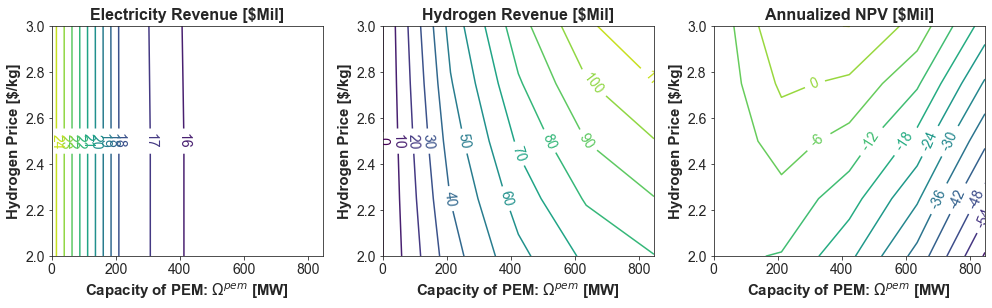

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))

res_df = res_df[res_df['pem_mw'].isin(pem_sizes)]
pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='annual_rev_E_mil',
                                aggfunc='mean')
cp = axs[0].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[0].set_title("Electricity Revenue [$Mil]", weight='bold')
axs[0].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[0].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='annual_rev_h2_mil',
                                aggfunc='mean')
cp = axs[1].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[1].set_title("Hydrogen Revenue [$Mil]", weight='bold')
axs[1].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[1].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

pivot_tab = res_df.pivot_table(index=f'h2_price_per_kg', 
                                columns=f"pem_mw", 
                                values='NPV Annualized [$Mil]',
                                aggfunc='mean')
cp = axs[2].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis')
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[2].set_title("Annualized NPV [$Mil]", weight='bold')
axs[2].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[2].set_ylabel("Hydrogen Price [$/kg]", weight='bold')

# plt.suptitle("Results from Price-taker")
plt.tight_layout()
plt.savefig("pem_pricetaker.pdf")

In [7]:
res_df.sort_values("NPV").tail(1)

,wind_mw,wind_mw_ub,batt_mw,pem_mw,pem_bar,pem_temp,tank_size,tank_type,turb_mw,h2_price_per_kg,annual_rev_h2,annual_rev_E,NPV,NPV [$Mil],annual_rev_E_mil,annual_rev_h2_mil,NPV Annualized [$Mil]
26,847.0,10000,0.0,423.5,1.01325,300,0,simple,1,3.0,8.595274e+07,1.587225e+07,6.810097e+07,68.100966,15.872251,85.952745,6.049234


## Surrogate Results

Text(0.5, 1.0, 'Wind-PEM Marginal Cost Curve at T=t')

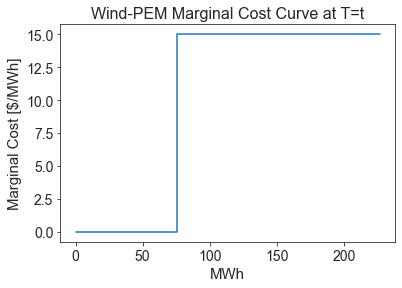

In [8]:
mws = np.linspace(0, 227.05, 10)
m_cost = [0 if mw < (227.05 - 127.05) else 15 for mw in mws]
plt.step(mws, m_cost)
plt.xlabel("MWh")
plt.ylabel("Marginal Cost [$/MWh]")
plt.title("Wind-PEM Marginal Cost Curve at T=t")

In [9]:
wind_cf = read_rts_gmlc_wind_inputs(rts_gmlc.source_data_path, gen_name="303_WIND_1", agg_func="first")['303_WIND_1-RTCF']
results_file_pattern = f"RE/input_data/sweep_parameters_15_{shortfall_price}.csv"
params_file = files("dynamic_sweep", pattern=results_file_pattern)
if not params_file:
    raise LookupError(f"No files found with pattern {results_file_pattern}")
params = pd.read_csv(params_file[0])

max_npv = 0
max_npv_size = 0
max_npv_bid = 0
sweep_df = None
records = []
csv_files_to_load = files("dynamic_sweep", pattern=f"RE/results_parameter_sweep_15_{shortfall_price}/*.csv")
for filename in csv_files_to_load:
    res = pd.read_csv(filename)
    ind = int(Path(filename).stem.split('_')[-1])
    pem_bid = params['PEM_bid'][ind]
    pem_size = params['PEM_power_capacity'][ind]
    if rt_revenue_only:
        e_revenue =(res["Dispatch"] * res["LMP"]).sum()
    else:
        e_revenue = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values * 847 - res['Dispatch'], 0, pem_size)
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    npv_ann = -cap_cost / PA + (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    if npv > max_npv:
        sweep_df = res.copy()
        max_npv = npv
        max_npv_bid = pem_bid
        max_npv_size = pem_size
    records.append({
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        "pem_bid": pem_bid,
        "pem_mw": pem_size,
        'NPV': npv,
        "NPV_ann": npv_ann})
sweep_results = pd.DataFrame(records)
sweep_results['pem_mw'] = sweep_results['pem_mw'].round(2)
sweep_results['pem_bid_round'] = sweep_results['pem_bid'].astype('int')
sweep_results['pem_mw_round'] = sweep_results['pem_mw'].astype('int')
sweep_results['e_revenue_mil'] = (sweep_results['e_revenue'] * 1e-6)
sweep_results['h_revenue_mil'] = (sweep_results['h_revenue'] * 1e-6)
sweep_results['NPV_bil'] = (sweep_results['NPV'] * 1e-9)
sweep_results['NPV_mil'] = (sweep_results['NPV'] * 1e-6)
sweep_results['NPV_ann_mil'] = (sweep_results['NPV_ann'] * 1e-6)

In [10]:
# get results file from RE_surrogate_optimization_steadystate.py
re_case_dir = Path.cwd() / "wind_PEM"
results = pd.read_csv(re_case_dir / f"surrogate_results_ss_rt_{shortfall_price}.csv")
results = results.drop(columns=["Unnamed: 0", 'wind_mw'])

pem_elec = results['h_revenue'] * 54.953 / h2_price / 1e3
cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + results['pem_mw'] * pem_cap_cost) * 1e3 
fixed_op_cost = (847 * wind_op_cost + results['pem_mw'] * pem_op_cost) * 1e3
var_op_cost = pem_var_cost * pem_elec
npv_ann = -cap_cost / PA + (results['e_revenue'] + results['h_revenue'] - fixed_op_cost - var_op_cost)

results['pem_mw'] = results['pem_mw'].round(2)
results['pem_bid_round'] = results['pem_bid'].astype('int')
results['pem_mw_round'] = results['pem_mw'].astype('int')
results['e_revenue_mil'] = (results['e_revenue'] * 1e-6)
results['h_revenue_mil'] = (results['h_revenue'] * 1e-6)
results['NPV_bil'] = (results['NPV'] * 1e-9)
results['NPV_mil'] = (results['NPV'] * 1e-6)
results['NPV_ann_mil'] = (npv_ann * 1e-6)


In [11]:
elec_rev_min = min(results['e_revenue_mil'].min(), sweep_results['e_revenue_mil'].min())
elec_rev_max = max(results['e_revenue_mil'].max(), sweep_results['e_revenue_mil'].max())
h2_rev_min = min(results['h_revenue_mil'].min(), sweep_results['h_revenue_mil'].min())
h2_rev_max = max(results['h_revenue_mil'].max(), sweep_results['h_revenue_mil'].max())
npv_min = min(results['NPV_ann_mil'].min(), sweep_results['NPV_ann_mil'].min())
npv_max = max(results['NPV_ann_mil'].max(), sweep_results['NPV_ann_mil'].max())

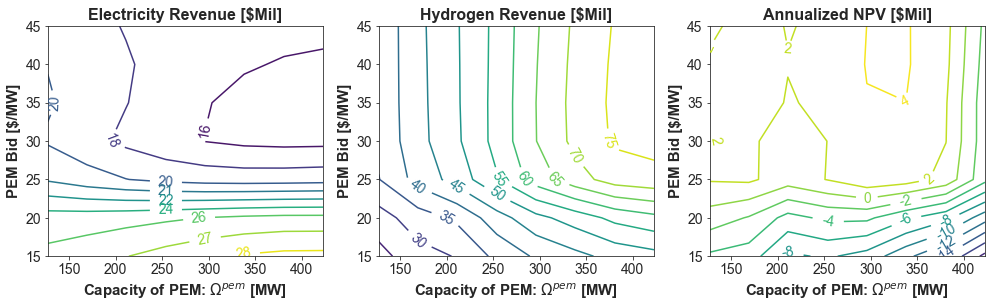

In [12]:
common_bids = set(results['pem_bid'].unique()).intersection(set(sweep_results['pem_bid'].unique()))
common_sizes = set(results['pem_mw'].round(2).unique()).intersection(set(sweep_results['pem_mw'].round(2).unique()))
results = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].round(2).isin(common_sizes))]

fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))

pivot_tab = results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean')
cp = axs[0].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=elec_rev_min, vmax=elec_rev_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[0].set_title("Electricity Revenue [$Mil]", weight='bold')
axs[0].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[0].set_ylabel("PEM Bid [$/MW]", weight='bold')

pivot_tab = results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean')
cp = axs[1].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=h2_rev_min, vmax=h2_rev_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[1].set_title("Hydrogen Revenue [$Mil]", weight='bold')
axs[1].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[1].set_ylabel("PEM Bid [$/MW]", weight='bold')

pivot_tab = results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_ann_mil',
                                aggfunc='mean')
cp = axs[2].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=npv_min, vmax=npv_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[2].set_title("Annualized NPV [$Mil]", weight='bold')
axs[2].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight='bold')
axs[2].set_ylabel("PEM Bid [$/MW]", weight='bold')

# plt.suptitle("Results from Surrogates")
plt.tight_layout()
plt.savefig("pem_surrogates.pdf")

In [13]:
results.sort_values("NPV").tail(1)

,pem_mw,pem_bid,e_revenue,h_revenue,NPV,freq_day_0,freq_day_1,freq_day_2,freq_day_3,freq_day_4,...,freq_day_17,freq_day_18,freq_day_19,pem_bid_round,pem_mw_round,e_revenue_mil,h_revenue_mil,NPV_bil,NPV_mil,NPV_ann_mil
160,338.8,40.0,16628409.41,71273345.41,47323370.08,0.080138,0.003963,0.389387,0.051582,0.04307,...,0.066932,0.000297,0.002411,40,338,16.628409,71.273345,0.047323,47.32337,4.203614


## Compare with Input Dataset from Prescient Sweep

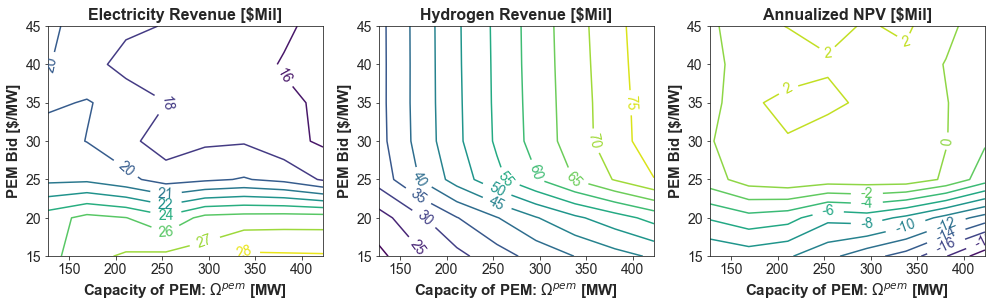

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))
pivot_tab = sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='e_revenue_mil',
                                aggfunc='mean')
cp = axs[0].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=elec_rev_min, vmax=elec_rev_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[0].set_title("Electricity Revenue [$Mil]", weight = 'bold')
axs[0].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight = 'bold')
axs[0].set_ylabel("PEM Bid [$/MW]", weight = 'bold')

pivot_tab = sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='h_revenue_mil',
                                aggfunc='mean')
cp = axs[1].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=h2_rev_min, vmax=h2_rev_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[1].set_title("Hydrogen Revenue [$Mil]", weight = 'bold')
axs[1].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight = 'bold')
axs[1].set_ylabel("PEM Bid [$/MW]", weight = 'bold')

pivot_tab = sweep_results.pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values='NPV_ann_mil',
                                aggfunc='mean')
cp = axs[2].contour(pivot_tab.columns.values, pivot_tab.index.values, pivot_tab.values, 12, cmap='viridis', vmin=npv_min, vmax=npv_max)
plt.clabel(cp, inline=True, fmt=lambda x: f"{x:.0f}")
axs[2].set_title("Annualized NPV [$Mil]", weight = 'bold')
axs[2].set_xlabel(r'Capacity of PEM: $\Omega^{pem}$ [MW]', weight = 'bold')
axs[2].set_ylabel("PEM Bid [$/MW]", weight = 'bold')

# plt.suptitle("Results from Sweep")
plt.tight_layout()
plt.savefig("pem_sweeps.pdf")

e_revenue_mil -0.09462143126783766 0.0727415516152309 -0.014745430414342443
h_revenue_mil -0.025627382705477313 0.23665536253863703 0.051632078637908786
NPV_ann_mil -20.290197304326814 22.285299198998306 0.13405520375651495


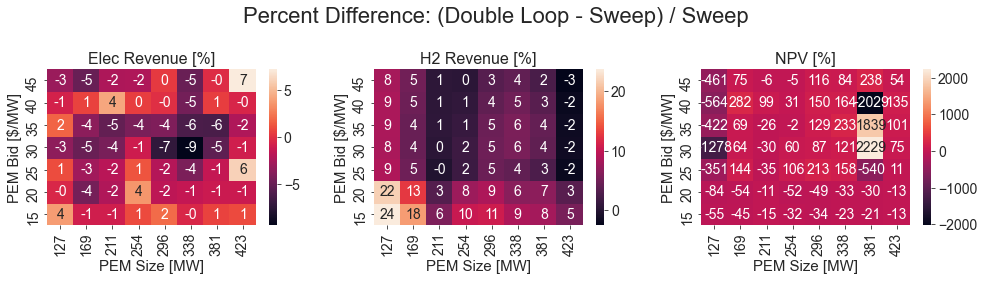

In [15]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = (results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean') - sweep_diff) / sweep_diff
    print(value, min(diff_df.min()), max(diff_df.max()), diff_df.values.flatten().mean())
    return diff_df * 1e2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue [%]")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue [%]")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_ann_mil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV [%]")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Percent Difference: (Double Loop - Sweep) / Sweep")
plt.tight_layout()

e_revenue_mil -1.6908745159763043 1.1414322825962007 -0.2771110724101305
h_revenue_mil -2.011101935747277 4.978020626902989 2.058634630309561
NPV_ann_mil -1.6018843839532286 5.4288597059054595 1.7815235578994308


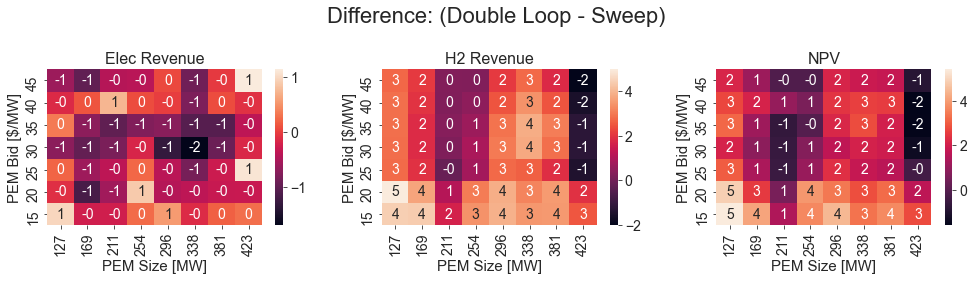

In [16]:
def calc_diff_df(value):
    sweep_diff = sweep_results[(sweep_results['pem_bid'].isin(common_bids)) & (sweep_results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df = results[(results['pem_bid'].isin(common_bids)) & (results['pem_mw'].isin(common_sizes))].pivot_table(index=f'pem_bid_round', 
                                columns=f"pem_mw_round", 
                                values=value,
                                aggfunc='mean')
    diff_df -= sweep_diff
    print(value, min(diff_df.min()), max(diff_df.max()), diff_df.values.flatten().mean())
    return diff_df

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(calc_diff_df('e_revenue_mil'), annot=True, fmt=".0f", ax=axs[0])
axs[0].set_title("Elec Revenue")
axs[0].set_xlabel("PEM Size [MW]")
axs[0].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('h_revenue_mil'), annot=True, fmt=".0f", ax=axs[1])
axs[1].set_title("H2 Revenue")
axs[1].set_xlabel("PEM Size [MW]")
axs[1].set_ylabel("PEM Bid [$/MW]")

sns.heatmap(calc_diff_df('NPV_ann_mil'), annot=True, fmt=".0f", ax=axs[2])
axs[2].set_title("NPV")
axs[2].set_xlabel("PEM Size [MW]")
axs[2].set_ylabel("PEM Bid [$/MW]")

for ax in axs:
    ax.invert_yaxis()

plt.suptitle("Difference: (Double Loop - Sweep)")
plt.tight_layout()

In [17]:
sweep_results.sort_values("NPV").tail(1)

,e_revenue,h_revenue,pem_bid,pem_mw,NPV,NPV_ann,pem_bid_round,pem_mw_round,e_revenue_mil,h_revenue_mil,NPV_bil,NPV_mil,NPV_ann_mil
10,1.904037e+07,4.908990e+07,35.0,211.75,2.869118e+07,2.548564e+06,35,211,19.040374,49.089901,0.028691,28.691183,2.548564


## Check Revenue of Optimal Model run through Double Loop

In [18]:
for run_type in ['optimal', 'sweep', 'pt_35']:
    run_df = pd.read_csv(Path("wind_PEM") / f"{run_type}_design_15_shortfall_{shortfall_price}_rth_1.csv")
    if run_type == 'optimal':
        pem_bid = 40.8
        pem_size = 317.4
    if 'pt' in run_type:
        pem_size = 322
    else:
        pem_bid = 35
        pem_size = 211.75

    if rt_revenue_only:
        e_revenue =(run_df["Dispatch"] * run_df["LMP"]).sum()
    else:
        e_revenue = (run_df["Dispatch DA"] * run_df["LMP DA"] + (run_df["Dispatch"] - run_df["Dispatch DA"]) * run_df["LMP"]).sum()
    pem_elec = np.clip(wind_cf.values[:8760] * 847 - run_df['Dispatch'], 0, pem_size)
    h2_price = 3
    h_revenue = pem_elec.sum() / 54.953 * h2_price * 1e3
    cap_cost = (847 * wind_cap_cost * int(include_wind_capital_cost) + pem_size * pem_cap_cost) * 1e3 
    fixed_op_cost = (847 * wind_op_cost + pem_size * pem_op_cost) * 1e3
    var_op_cost = pem_var_cost * pem_elec.sum()
    npv = -cap_cost + PA * (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    npv_ann = -cap_cost / PA + (e_revenue + h_revenue - fixed_op_cost - var_op_cost)
    print(run_type, {
        "e_revenue": e_revenue,
        "h_revenue": h_revenue,
        'NPV': npv,
        "NPV_ann": npv_ann})

optimal {'e_revenue': 19327961.771614905, 'h_revenue': 68224479.80261314, 'NPV': 70359584.59069425, 'NPV_ann': 6249861.313386045}
sweep {'e_revenue': 20830121.123166505, 'h_revenue': 51435875.02247375, 'NPV': 75250235.95798433, 'NPV_ann': 6684285.321934372}
pt_35 {'e_revenue': 20095044.239321932, 'h_revenue': 68477166.2102342, 'NPV': 81839921.64920259, 'NPV_ann': 7269630.188714124}


## Compare Validation Run of the PCM Enumeration (Sweep) with the Original

Index of biggest difference in RT Revenue:  2790


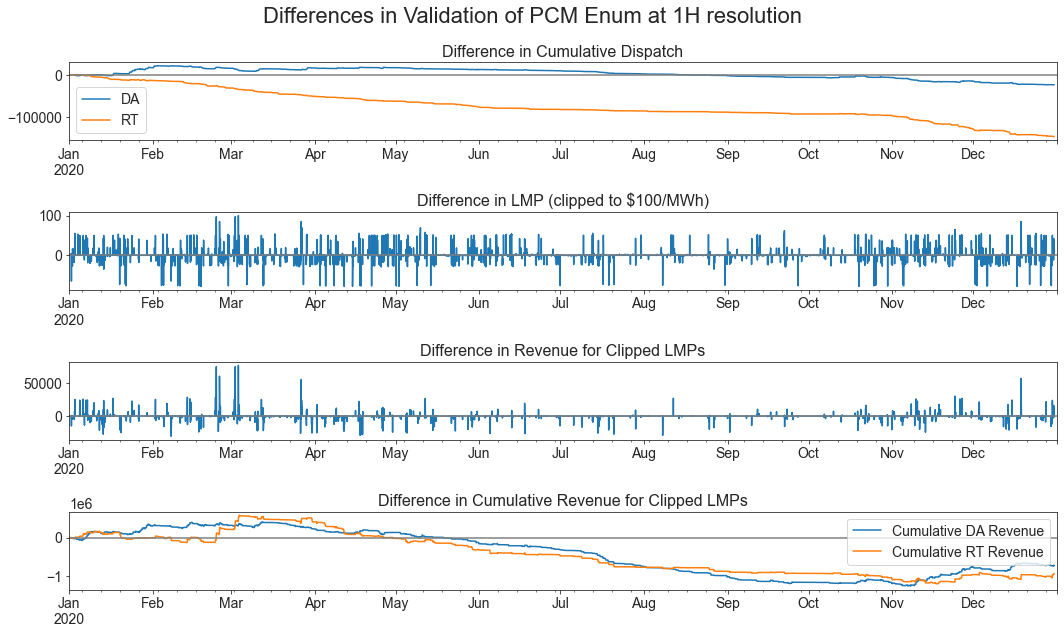

In [19]:
validation_df = pd.read_csv(Path("wind_PEM") / f"sweep_design_15_shortfall_{shortfall_price}_rth_1.csv")
validation_df = validation_df.set_index("Unnamed: 0")
validation_df.index = pd.to_datetime(validation_df.index)
sweep_df.index = pd.to_datetime(sweep_df['Datetime'])

fig, axs = plt.subplots(4, 1, figsize=(15, 9))
period = "1H"
validation_df = validation_df.resample(period).mean()#.head(2790 + 12).tail(24)
pcm_enum_df = sweep_df.resample(period).mean()#.head(2790 + 12).tail(24)
validation_df['RT Revenue'] = validation_df['LMP'] * validation_df['Dispatch']
pcm_enum_df['RT Revenue'] = pcm_enum_df['LMP'] * pcm_enum_df['Dispatch']
print("Index of biggest difference in RT Revenue: ", (validation_df['RT Revenue'] - pcm_enum_df['RT Revenue']).argmax())

lmp_max = 100
validation_df['LMP Clipped'] = validation_df['LMP'].clip(lower=-lmp_max, upper=lmp_max)
validation_df['RT Revenue Clipped'] = validation_df['LMP Clipped'] * validation_df['Dispatch']
validation_df['DA Revenue Clipped'] = validation_df['LMP DA'].clip(lower=-lmp_max, upper=lmp_max) * validation_df['Dispatch DA']
pcm_enum_df['LMP Clipped'] = pcm_enum_df['LMP'].clip(lower=-lmp_max, upper=lmp_max)
pcm_enum_df['RT Revenue Clipped'] = pcm_enum_df['LMP Clipped'] * pcm_enum_df['Dispatch']
pcm_enum_df['DA Revenue Clipped'] = pcm_enum_df['LMP DA'].clip(lower=-lmp_max, upper=lmp_max) * pcm_enum_df['Dispatch DA']

(validation_df['Dispatch DA'].cumsum() - pcm_enum_df['Dispatch DA'].cumsum()).plot(ax=axs[0], label="DA")
(validation_df['Dispatch'].cumsum() - pcm_enum_df['Dispatch'].cumsum()).plot(ax=axs[0], label="RT")
axs[0].legend()
axs[0].axhline(y=0, color='grey')
axs[0].set_title("Difference in Cumulative Dispatch")
(validation_df['LMP Clipped'] - pcm_enum_df['LMP Clipped']).plot(ax=axs[1])
axs[1].axhline(y=0, color='grey')
axs[1].set_title(f"Difference in LMP (clipped to ${lmp_max}/MWh)")
(validation_df['RT Revenue Clipped'] - pcm_enum_df['RT Revenue Clipped']).plot(ax=axs[2])
axs[2].axhline(y=0, color='grey')
axs[2].set_title("Difference in Revenue for Clipped LMPs")
(validation_df['DA Revenue Clipped'].cumsum() - pcm_enum_df['DA Revenue Clipped'].cumsum()).plot(ax=axs[3], label='Cumulative DA Revenue')
(validation_df['RT Revenue Clipped'].cumsum() - pcm_enum_df['RT Revenue Clipped'].cumsum()).plot(ax=axs[3], label='Cumulative RT Revenue')
axs[3].legend()
axs[3].axhline(y=0, color='grey')
axs[3].set_title("Difference in Cumulative Revenue for Clipped LMPs")
plt.suptitle(f"Differences in Validation of PCM Enum at {period} resolution")
plt.tight_layout()
plt.savefig("DoubleLoop-Sweep.png")

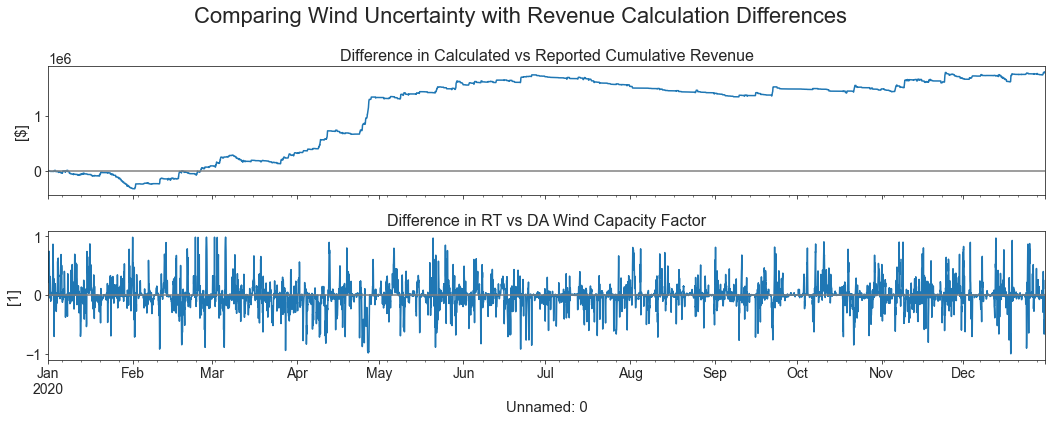

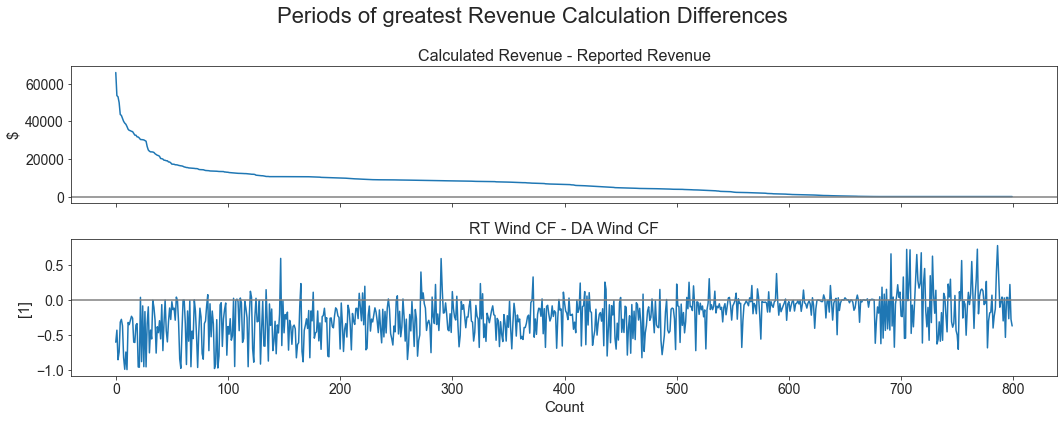

In [20]:
# For the validation run, check the difference in reported revenue vs manually calculated from LMPs and Dispatch to see Reserve revenues
rev_calc = validation_df['LMP DA'] * validation_df['Dispatch DA'] + validation_df['LMP'] * (validation_df['Dispatch'] - validation_df['Dispatch DA'])
rev_report = validation_df['Unit Market Revenue']
wind_diff = run_df['303_WIND_1-RTCF'] - run_df['303_WIND_1-DACF']
wind_diff.index = rev_calc.index

fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
(rev_calc.cumsum() - rev_report.cumsum()).plot(ax=axs[0])
axs[0].axhline(y=0, color='grey')
axs[0].set_title("Difference in Calculated vs Reported Cumulative Revenue")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("[$]")
wind_diff.plot(ax=axs[1])
axs[1].axhline(y=0, color='grey')
axs[1].set_title("Difference in RT vs DA Wind Capacity Factor")
axs[1].set_ylabel("[1]")
plt.suptitle("Comparing Wind Uncertainty with Revenue Calculation Differences")
plt.tight_layout()

# Sort the above by greatest Revenue Calculation difference to see any pattern with the wind capacity factor difference
validation_df['Rev Diff'] = rev_calc - rev_report
validation_df['Wind Diff'] = wind_diff.values
df_tmp = validation_df.sort_values("Rev Diff", ascending=False)[['Rev Diff', 'Wind Diff']]

fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axs[0].plot(df_tmp['Rev Diff'].head(800).values)
axs[0].set_title("Calculated Revenue - Reported Revenue")
axs[0].axhline(y=0, color='grey')
axs[0].set_ylabel("$")
axs[1].plot(df_tmp['Wind Diff'].head(800).values)
axs[1].set_title("RT Wind CF - DA Wind CF")
axs[1].axhline(y=0, color='grey')
axs[1].set_ylabel("[1]")
axs[1].set_xlabel("Count")
plt.suptitle("Periods of greatest Revenue Calculation Differences")
plt.tight_layout()